<div align="center">

  <img src="https://raw.githubusercontent.com/The-RL-Hub/The-RL-Hub.github.io/main/Pictures/logo.png" width="180" height="180" style="margin-bottom: 10px;">
  
  <h1></h1>
  <h1 style="color:#0F5298; font-size: 40px; font-weight: bold; margin-bottom: 5px;">The RLHub Notebook</h1>
  <h2 style="color:#0F5298; font-size: 32px; font-weight: normal; margin-top: 0px;">Multi‑Armed Bandits</h2>

  <h3 style="color:#696880; font-size: 22px; margin-top: 20px;">May 2025</h3>

  <hr style="border: 1px solid #0F5298; width: 80%; margin-top: 30px;">

</div>


This notebook is **self‑contained** and aimed at practitioners who want to _experiment, benchmark,_ and _extend_ multi‑armed bandit algorithms.  


## Table of Contents
1. [Prerequisites & setup](#setup)
2. [Bandit environments](#env)
   * Bernoulli & Gaussian
   * Non‑stationary drift
   * Gymnasium wrapper
3. [Algorithm zoo](#algos)
   * ε‑Greedy (fixed & decaying)
   * Optimistic Initialization
   * UCB family (UCB1, KL‑UCB)
   * Thompson Sampling (Beta & Gaussian)
4. [Experiment framework](#exp)
   * Reproducible multi‑run evaluation
   * Cumulative reward & regret metrics
5. [Benchmarking & visualisation](#bench)
6. [Hyper‑parameter search](#sweep)
7. [Interactive playground](#widget)
8. [Advanced Algorithms](#adval)
   * Gradient Bandit
   * Exp3
   * Gamma‑Poisson Thompson Sampling
   * Example — Gradient vs Exp3 on drifting Bernoulli
   * Example — Poisson bandit


## 1. Prerequisites & setup <a id='setup'></a>

In [1]:
!pip install gymnasium matplotlib ipywidgets mabwiser banditpylib

ERROR: Could not find a version that satisfies the requirement banditpylib (from versions: none)
ERROR: No matching distribution found for banditpylib


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from itertools import product
from collections import defaultdict
from ipywidgets import interact, FloatSlider, IntSlider

plt.rcParams['figure.figsize'] = (9, 5)

def set_seed(seed=123):
    np.random.seed(seed)

set_seed()

## 2. Bandit environments <a id='env'></a>

### 2.1 Plain Bernoulli & Gaussian implementations

In [34]:
class BernoulliBandit:
    """Stationary K‑armed Bernoulli bandit."""
    def __init__(self, probs):
        self.probs = np.asarray(probs)
        self.k = len(probs)

    def pull(self, arm: int):
        return 1.0 if np.random.rand() < self.probs[arm] else 0.0

    def optimal_mean(self):
        return self.probs.max()

    def __repr__(self):
        return f"BernoulliBandit(k={self.k}, probs={self.probs})"


class GaussianBandit:
    """Gaussian rewards with known variance=1."""
    def __init__(self, means, sigma=1.0):
        self.means = np.asarray(means)
        self.sigma = sigma
        self.k = len(means)

    def pull(self, arm: int):
        return np.random.normal(self.means[arm], self.sigma)

    def optimal_mean(self):
        return self.means.max()

    def __repr__(self):
        return f"GaussianBandit(k={self.k}, means={self.means})"

### 2.2 Non‑stationary drift (Random Walk)

In [ ]:
class NonStationaryBernoulli(BernoulliBandit):
    """Underlying probabilities perform a random walk after each pull."""
    def __init__(self, probs, drift_std=0.01):
        super().__init__(probs)
        self.drift_std = drift_std

    def pull(self, arm: int):
        self.probs = np.clip(self.probs + np.random.normal(0, self.drift_std, size=self.k), 0.01, 0.99)
        return super().pull(arm)

### 2.3 Gymnasium wrapper
Adapting bandits to a standard RL interface lets us reuse SB3 training loops.

In [35]:
class GymBandit(gym.Env):
    """Minimal Gym wrapper for any bandit environment."""
    metadata = {"render_modes": []}

    def __init__(self, bandit):
        self.bandit = bandit
        self.action_space = gym.spaces.Discrete(bandit.k)
        self.observation_space = gym.spaces.Discrete(1)
        self.reward_range = (0, 1)

    def reset(self, seed=None, options=None):
        if seed is not None:
            set_seed(seed)
        return 0, {}

    def step(self, action):
        reward = self.bandit.pull(action)
        terminated = True
        return 0, reward, terminated, False, {}

## 3. Algorithm zoo <a id='algos'></a>

All algorithms inherit a shared skeleton to minimise code duplication.

In [36]:
class Agent:
    def __init__(self, k, steps):
        self.k, self.steps = k, steps
        self.Q = np.zeros(k)
        self.N = np.zeros(k)
        self.actions = np.zeros(steps, dtype=int)
        self.rewards = np.zeros(steps)

    def select_action(self, t):
        raise NotImplementedError

    def update(self, arm, reward):
        self.N[arm] += 1
        self.Q[arm] += (reward - self.Q[arm]) / self.N[arm]

    def play(self, env):
        for t in range(self.steps):
            a = self.select_action(t)
            r = env.pull(a)
            self.update(a, r)
            self.actions[t] = a
            self.rewards[t] = r
        return self.rewards

### 3.1 ε‑Greedy (fixed & decaying)

In [37]:
class EpsilonGreedy(Agent):
    def __init__(self, k, steps, epsilon=0.1, decay=None):
        super().__init__(k, steps)
        self.epsilon, self.decay = epsilon, decay

    def select_action(self, t):
        eps = self.epsilon * (self.decay ** t) if self.decay else self.epsilon
        if np.random.rand() < eps:
            return np.random.randint(self.k)
        return np.argmax(self.Q)

### 3.2 Optimistic initialisation

In [38]:
class OptimisticGreedy(Agent):
    def __init__(self, k, steps, q0=5.0):
        super().__init__(k, steps)
        self.Q.fill(q0)

    def select_action(self, t):
        return np.argmax(self.Q)

### 3.3 Upper Confidence Bounds

In [39]:
class UCB1(Agent):
    def __init__(self, k, steps, c=2):
        super().__init__(k, steps); self.c = c
    def select_action(self, t):
        bonus = self.c * np.sqrt(np.log(t + 1) / (self.N + 1e-9))
        return np.argmax(self.Q + bonus)

class KL_UCB(Agent):
    """KL‑UCB for Bernoulli bandits (Garivier & Cappé)."""
    def __init__(self, k, steps, c=3):
        super().__init__(k, steps); self.c = c

    @staticmethod
    def kl(p, q):
        p = np.clip(p, 1e-9, 1-1e-9)
        q = np.clip(q, 1e-9, 1-1e-9)
        return p*np.log(p/q) + (1-p)*np.log((1-p)/(1-q))

    def select_action(self, t):
        upper = np.zeros(self.k)
        for arm in range(self.k):
            if self.N[arm] == 0:
                return arm
            mu = self.Q[arm]
            bound = (np.log(t) + self.c*np.log(np.log(t+1))) / self.N[arm]
            q = mu
            low, high = mu, 1
            for _ in range(25):
                mid = (low + high) / 2
                if self.kl(mu, mid) > bound:
                    high = mid
                else:
                    low = mid
            upper[arm] = (low + high) / 2
        return np.argmax(upper)

### 3.4 Thompson Sampling (Beta‑Bernoulli & Gaussian)

In [40]:
class BetaThompson(Agent):
    def __init__(self, k, steps):
        super().__init__(k, steps)
        self.alpha = np.ones(k)
        self.beta = np.ones(k)

    def select_action(self, t):
        return np.argmax(np.random.beta(self.alpha, self.beta))

    def update(self, arm, reward):
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward
        super().update(arm, reward)

class GaussianThompson(Agent):
    """Known variance=1, Normal‑Normal model"""
    def __init__(self, k, steps, prior_var=1.0):
        super().__init__(k, steps)
        self.mean = np.zeros(k)
        self.var = np.ones(k) * prior_var

    def select_action(self, t):
        sample = np.random.normal(self.mean, np.sqrt(self.var))
        return np.argmax(sample)

    def update(self, arm, reward):
        self.var[arm] = 1 / (1 + 1/self.var[arm])
        self.mean[arm] = self.var[arm] * (reward + self.mean[arm]/self.var[arm])
        super().update(arm, reward)

## 4. Experiment framework <a id='exp'></a>

In [41]:

def simulate(agent_cls, env, runs=500, **agent_kwargs):
    rewards = np.zeros((runs, agent_cls.steps))
    for r in range(runs):
        agent = agent_cls(env.k, agent_cls.steps, **agent_kwargs)
        rewards[r] = agent.play(env)
    mean_reward = rewards.mean(axis=0)
    cum_reward = mean_reward.cumsum()
    regret = env.optimal_mean()*np.arange(1, agent_cls.steps+1) - cum_reward
    return mean_reward, regret


## 5. Benchmarking & visualisation <a id='bench'></a>

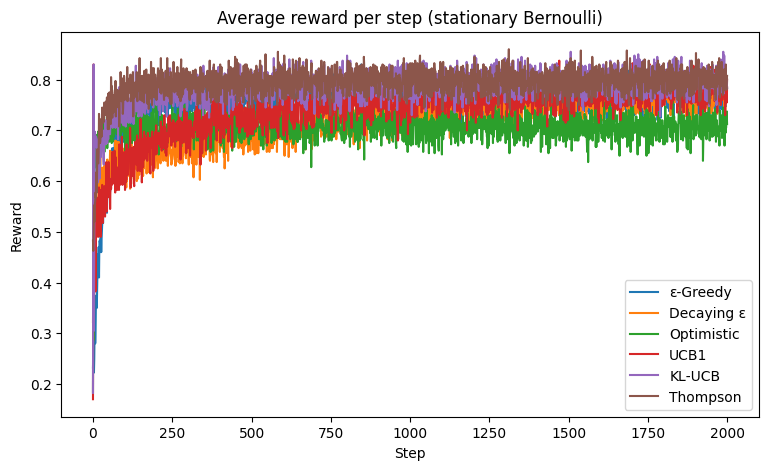

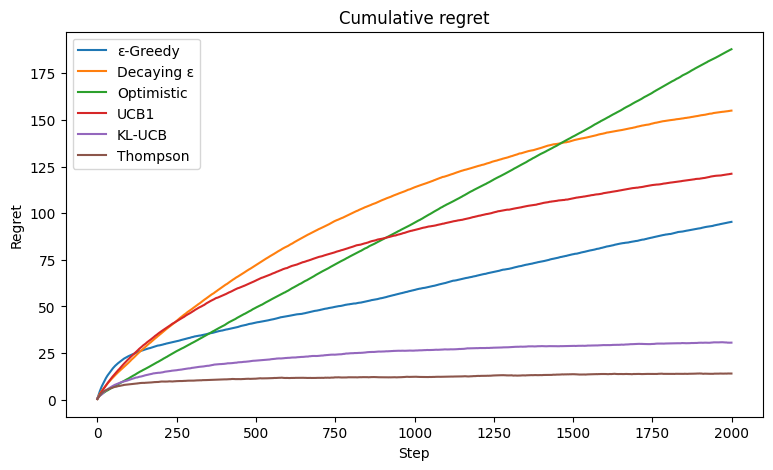

In [42]:
STEPS = 2000
for cls in (EpsilonGreedy, OptimisticGreedy, UCB1, KL_UCB, BetaThompson):
    cls.steps = STEPS

bandit = BernoulliBandit([0.2, 0.5, 0.8, 0.3])
agents = {
    "ε‑Greedy": (EpsilonGreedy, dict(epsilon=0.1)),
    "Decaying ε": (EpsilonGreedy, dict(epsilon=0.5, decay=0.999)),
    "Optimistic": (OptimisticGreedy, dict(q0=5)),
    "UCB1": (UCB1, dict(c=2)),
    "KL‑UCB": (KL_UCB, dict(c=3)),
    "Thompson": (BetaThompson, dict())
}

reward_curves, regret_curves = {}, {}
for name, (cls, kw) in agents.items():
    r, reg = simulate(cls, bandit, runs=400, **kw)
    reward_curves[name] = r
    regret_curves[name] = reg

for n, cur in reward_curves.items():
    plt.plot(cur, label=n)
plt.title("Average reward per step (stationary Bernoulli)")
plt.xlabel("Step"); plt.ylabel("Reward"); plt.legend()
plt.show()

for n, cur in regret_curves.items():
    plt.plot(cur, label=n)
plt.title("Cumulative regret"); plt.xlabel("Step"); plt.ylabel("Regret"); plt.legend()
plt.show()

## 6. Hyper‑parameter search <a id='sweep'></a>
Grid‑search over ε and UCB `c` values to show sensitivity.

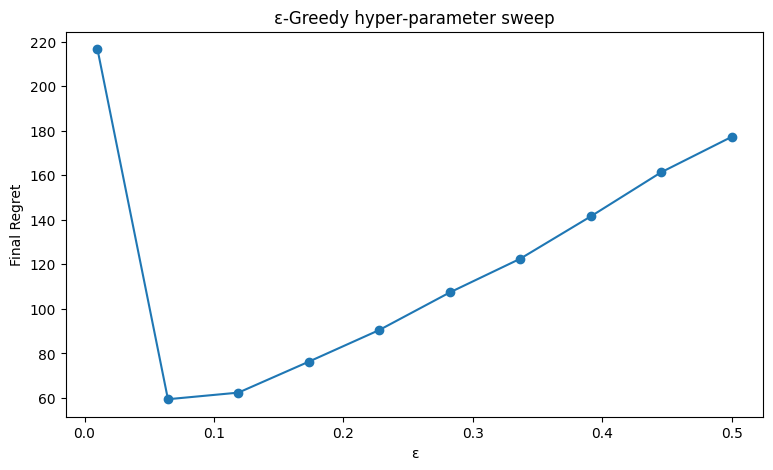

In [43]:
def sweep_epsilons(eps_values, env, steps=1000):
    EpsilonGreedy.steps = steps
    results = {}
    for eps in eps_values:
        _, reg = simulate(EpsilonGreedy, env, runs=300, epsilon=eps)
        results[eps] = reg[-1]
    return results

eps_grid = np.linspace(0.01, 0.5, 10)
final_regret = sweep_epsilons(eps_grid, bandit)
plt.plot(eps_grid, list(final_regret.values()), marker='o')
plt.xlabel("ε"); plt.ylabel("Final Regret"); plt.title("ε‑Greedy hyper‑parameter sweep")
plt.show()

## 7. Interactive playground <a id='widget'></a>

In [44]:
def interactive_greedy(epsilon=0.1, decay=1.0, steps=500):
    EpsilonGreedy.steps = steps
    mean_r, reg = simulate(EpsilonGreedy, bandit, runs=200, epsilon=epsilon, decay=decay)
    plt.plot(reg)
    plt.xlabel("Step"); plt.ylabel("Regret")
    plt.title(f"ε‑Greedy Regret (ε={epsilon}, decay={decay})")
    plt.show()

interact(interactive_greedy,
         epsilon=FloatSlider(min=0.01, max=0.6, step=0.02, value=0.1),
         decay=FloatSlider(min=0.95, max=1.0, step=0.001, value=1.0),
         steps=IntSlider(min=200, max=3000, step=100, value=500));

interactive(children=(FloatSlider(value=0.1, description='epsilon', max=0.6, min=0.01, step=0.02), FloatSlider…

## 8. Advanced Algorithms <a id='adval'></a>
this part focuses on **advanced algorithms, new distributions, and challenge problems**.



In [45]:
class Agent:
    def __init__(self, k, steps):
        self.k, self.steps = k, steps
        self.Q = np.zeros(k); self.N = np.zeros(k)
        self.rewards = np.zeros(steps)
    def select_action(self, t): raise NotImplementedError
    def update(self, arm, r):
        self.N[arm]+=1
        self.Q[arm]+= (r-self.Q[arm])/self.N[arm]
    def play(self, env):
        for t in range(self.steps):
            a = self.select_action(t)
            r = env.pull(a)
            self.update(a,r)
            self.rewards[t]=r
        return self.rewards

def simulate(agent_cls, env, runs=300, **kw):
    R=np.zeros((runs, agent_cls.steps))
    for i in range(runs):
        R[i]=agent_cls(env.k, agent_cls.steps, **kw).play(env)
    avg=R.mean(0)
    regret=env.optimal_mean()*np.arange(1,agent_cls.steps+1)-avg.cumsum()
    return avg, regret

In [46]:
class BernoulliBandit:
    def __init__(self, probs): self.probs=np.asarray(probs); self.k=len(probs)
    def pull(self, arm): return 1.0 if np.random.rand()<self.probs[arm] else 0.0
    def optimal_mean(self): return self.probs.max()

class NonStationaryBernoulli(BernoulliBandit):
    def __init__(self, probs, drift_std=0.01):
        super().__init__(probs); self.drift_std=drift_std
    def pull(self, arm):
        self.probs=np.clip(self.probs+np.random.normal(0,self.drift_std,self.k),0.01,0.99)
        return super().pull(arm)

In [47]:
class PoissonBandit:
    def __init__(self, lambdas): self.lambdas=np.asarray(lambdas); self.k=len(lambdas)
    def pull(self, arm): return np.random.poisson(self.lambdas[arm])
    def optimal_mean(self): return self.lambdas.max()

### 8.1. Gradient Bandit

In [48]:
class GradientBandit(Agent):
    def __init__(self, k, steps, alpha=0.1, baseline=True):
        super().__init__(k, steps); self.H=np.zeros(k)
        self.alpha=alpha; self.baseline=baseline; self.avg_r=0
    def _softmax(self):
        e=np.exp(self.H-self.H.max()); return e/e.sum()
    def select_action(self, t):
        probs=self._softmax(); self.last_probs=probs
        return np.random.choice(self.k,p=probs)
    def update(self, arm, r):
        if self.baseline:
            self.avg_r+=(r-self.avg_r)/(self.N.sum()+1)
            b=self.avg_r
        else: b=0
        self.H+=self.alpha*(r-b)*(np.eye(self.k)[arm]-self.last_probs)
        super().update(arm,r)

### 8.2. Exp3


In [49]:
class Exp3(Agent):
    def __init__(self, k, steps, gamma=0.07):
        super().__init__(k,steps); self.gamma=gamma; self.w=np.ones(k)
    def _probs(self):
        return (1-self.gamma)*self.w/self.w.sum()+self.gamma/self.k
    def select_action(self,t):
        p=self._probs(); self.last_p=p; return np.random.choice(self.k,p=p)
    def update(self,arm,r):
        est=r/self.last_p[arm]; self.w[arm]*=np.exp(self.gamma*est/self.k)
        super().update(arm,r)

### 8.3. Gamma‑Poisson Thompson Sampling

In [50]:
class GammaPoissonTS(Agent):
    def __init__(self,k,steps,alpha=1,beta=1):
        super().__init__(k,steps); self.a=np.ones(k)*alpha; self.b=np.ones(k)*beta
    def select_action(self,t):
        sample=np.random.gamma(self.a,1/self.b); return np.argmax(sample)
    def update(self,arm,r):
        self.a[arm]+=r; self.b[arm]+=1
        super().update(arm,r)

### 8.4. Example — Gradient vs Exp3 on drifting Bernoulli

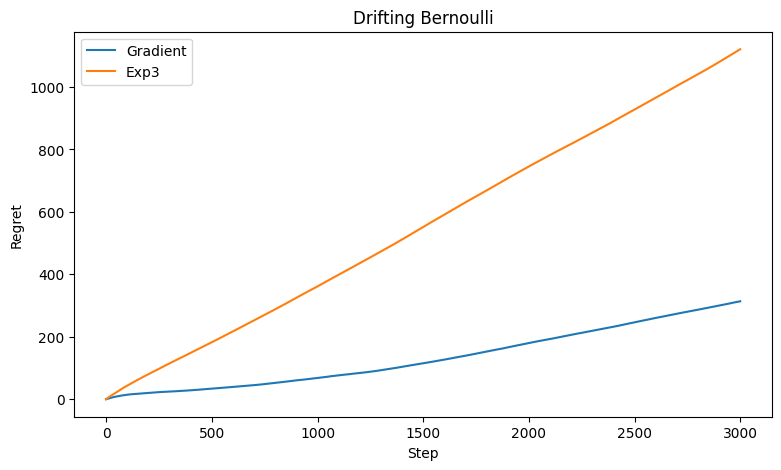

In [51]:
STEPS=3000
GradientBandit.steps=STEPS; Exp3.steps=STEPS
env=NonStationaryBernoulli([0.3,0.5,0.4],drift_std=0.02)
algs={'Gradient':(GradientBandit,dict(alpha=0.1)),
      'Exp3':(Exp3,dict(gamma=0.07))}
for name,(cls,kw) in algs.items():
    _,reg=simulate(cls,env,runs=300,**kw)
    plt.plot(reg,label=name)
plt.legend(); plt.xlabel('Step'); plt.ylabel('Regret')
plt.title('Drifting Bernoulli'); plt.show()

### 8.5. Example — Poisson bandit



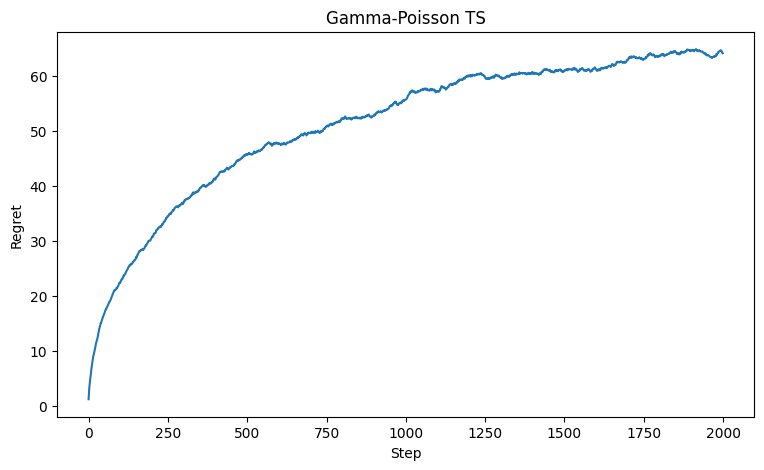

In [52]:
GammaPoissonTS.steps=2000
pois_env=PoissonBandit([1,3,2.5,0.5])
_,reg=simulate(GammaPoissonTS,pois_env,runs=400)
plt.plot(reg); plt.xlabel('Step'); plt.ylabel('Regret'); plt.title('Gamma‑Poisson TS'); plt.show()